# Gene set enrichment analysis of rho scores

<!-- Luke and Ray has shared the CRISPRi screening results which was analyzed with [ScreenProcessing](https://github.com/mhorlbeck/ScreenProcessing) pipeline.  -->

<!-- - $\gamma$ - gamma score -->
<!-- - $\rho$ - rho score -->

<!-- - Load screening result tables into python 
- Make sure gene names are correctly assigned 
 -->

<!-- Alex Ge: 
> If we do Enrichr analysis on the resistance/sensitivity hits defined by Max’s cutoffs, (n = 418 genes), we do see mRNA methylation (adj p = 0.018) and RNA destabilization (adj p = 0.005) come out as significant GO biological processes. METTL3 is included in these GO terms.

> If we do Enrichr analysis on just the resistance hits (n = 197), mRNA methylation is even more significant (adj p = 0.002), which makes sense since we see more METTL3 biology on the resistance side. It is one of the top five GO terms by adjusted P-value.

> This analysis was done today with the 2021 GO terms, which have updated annotations for the newer m6A genes. When I did the same Enrichr analysis in 2018, RNA destabilization and mRNA methylation were not as significant since the GO annotations were not updated.

> I think Enrichr analysis might make more sense here – in Abe’s analysis, I can see that a lot of rho scores that are < 0.2 are being included in the analysis; these are likely to be statistically insignificant. It also looks graphically like the highest bin is including rho values that are < 0?
 -->
- tool: blitzgsea, https://github.com/MaayanLab/blitzgsea

In [174]:
import sys
import pandas as pd
import numpy as np 
from itertools import chain, product

sys.path.append("../../")
pager_dir = "/data_gilbert/home/aarab/tools/pager/"
pager_annotation_path = '/data_gilbert/home/aarab/tools/pager/annotations/human'

from scripts.util import *
from matplotlib_venn import venn2
from IPython.display import IFrame

In [175]:
# import gseapy

In [3]:
def get_sig_gsea_results(result,variable,threshold):
    return result[result[variable] < threshold]

In [4]:
wd = '/data_gilbert/home/aarab/AML/Decitabine-treatment/DAC'

In [5]:
data = load_data(screens=True,wd=wd)

In [106]:
# data.keys()

In [140]:
cell_lines_rho = pd.read_csv('cell_lines_DAC_rho.txt',sep='\t')

## Run GSEA

In [7]:
import blitzgsea as blitz
import urllib.request
import pandas as pd

In [8]:
def get_rho_for_gsea(label):
    rho_df = data[f'{label}_rho'].astype(np.double).copy()
    rho_df.columns = ['score','stat']
    
    rho_score = rho_df.score.reset_index()
    rho_score = rho_score.dropna()
    
    rho_stat =  1 - rho_df.stat
    rho_stat = rho_stat.reset_index()
    rho_stat = rho_stat.dropna()
    
    return rho_score, rho_stat

In [9]:
hl60_rho_score,hl60_rho_pval = get_rho_for_gsea('hl60_exp1')

In [10]:
molm13_rho_score,molm13_rho_pval = get_rho_for_gsea('molm13_exp')

In [11]:
skm1_rho_score,skm1_rho_pval = get_rho_for_gsea('skm1_exp')

# 

In [12]:
table_s1 = {}

## Regardless of direction

#### c5_go_gmt

In [13]:
c5_go_gmt = blitz.enrichr.read_gmt(
    f'{pager_annotation_path}/msigdb_v7.4_c5.go/c5.go.v7.4.symbols.gmt'
)

In [181]:
pd.Series(c5_go_gmt['GOMF_DNA_BINDING_TRANSCRIPTION_FACTOR_ACTIVITY']).to_csv('GOMF_DNA_BINDING_TRANSCRIPTION_FACTOR_ACTIVITY.txt',index=False,header=False)

In [14]:
def run_rho_gsea(rho,gmt=c5_go_gmt,min_size=200):
    signature = rho.copy()

    result = blitz.gsea(
        signature=signature,
        library=gmt,
        min_size=min_size,
        # max_size=250,
        verbose=True
    )
    
    return signature, result

In [15]:
gsea_res = {}

In [16]:
gsea_res['HL-60'] = {}

In [17]:
gsea_res['HL-60']['signature'], gsea_res['HL-60']['result_go'] = run_rho_gsea(hl60_rho_pval)

Enrichment : 100%|██████████| 10185/10185 [00:01<00:00, 6239.33it/s]
/data_gilbert/home/aarab/anaconda3/envs/down/lib/python3.10/site-packages/statsmodels/stats/multitest.py:155: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


In [18]:
gsea_res['MOLM-13'] = {}

In [19]:
gsea_res['MOLM-13']['signature'], gsea_res['MOLM-13']['result_go'] = run_rho_gsea(molm13_rho_pval)

Enrichment : 100%|██████████| 10185/10185 [00:01<00:00, 6339.31it/s]
/data_gilbert/home/aarab/anaconda3/envs/down/lib/python3.10/site-packages/statsmodels/stats/multitest.py:155: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


In [20]:
gsea_res['SKM-1'] = {}

In [21]:
gsea_res['SKM-1']['signature'], gsea_res['SKM-1']['result_go'] = run_rho_gsea(skm1_rho_pval)

Enrichment : 100%|██████████| 10185/10185 [00:01<00:00, 6013.42it/s]
/data_gilbert/home/aarab/anaconda3/envs/down/lib/python3.10/site-packages/statsmodels/stats/multitest.py:155: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


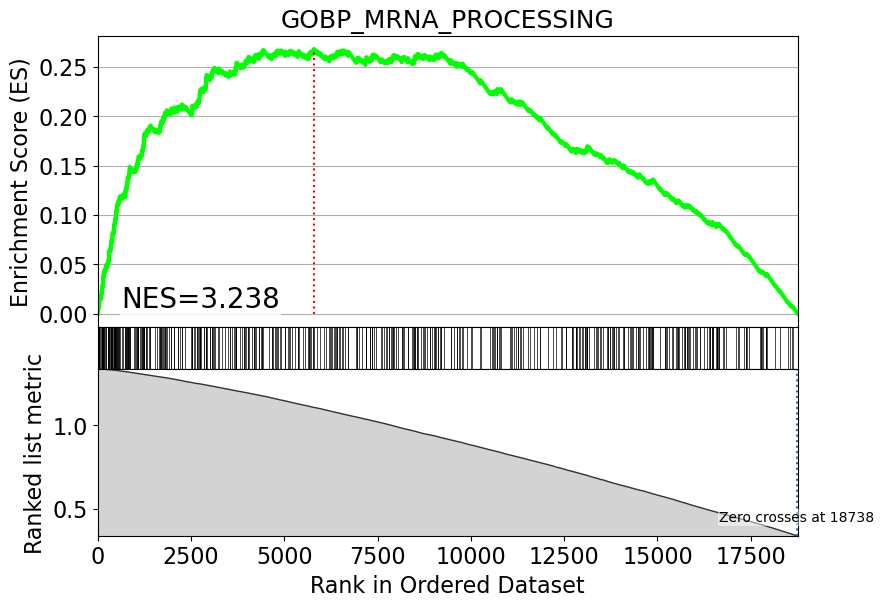

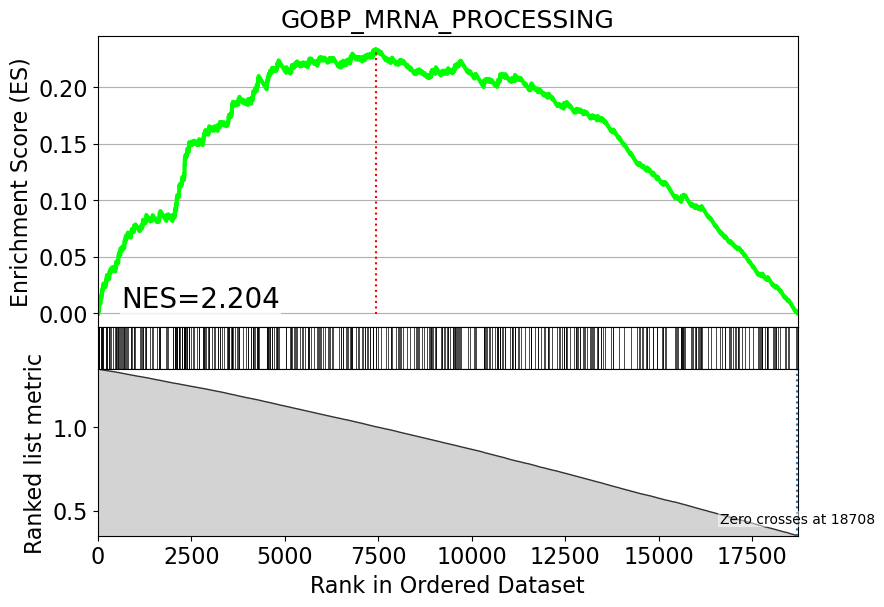

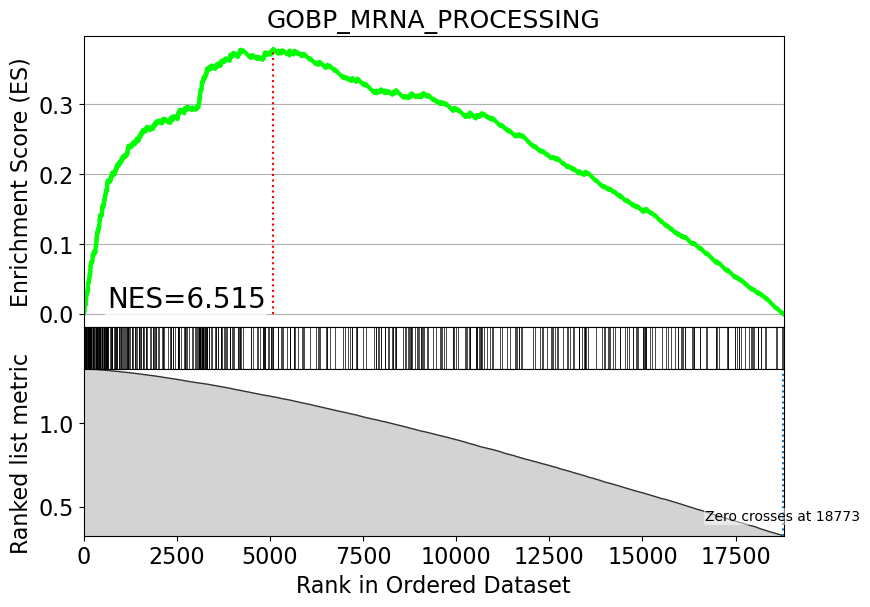

In [23]:
for cell_line in gsea_res.keys():
    # plot the enrichment results and save to pdf
    fig = blitz.plot.running_sum(
        gsea_res[cell_line]['signature'], 
        "GOBP_MRNA_PROCESSING", 
        c5_go_gmt,
        gsea_res[cell_line]['result_go'],
        compact=False)
    # fig.tight_layout()
    fig.savefig(f"plots/{cell_line}-CRISPRi-rho-gsea-GOBP_MRNA_PROCESSING.pdf", bbox_inches='tight')

In [24]:
result_go = pd.concat(
    dict([(k,gsea_res[k]['result_go']) for k in gsea_res]),axis=1
)

In [111]:
# result_go.sort_values([('HL-60', 'nes')], ascending=False)

In [25]:
# result_go.dropna()

In [26]:
table_s1['Regardless of direction'] = result_go

___

In [27]:
# pd.DataFrame(c5_go_gmt['GOBP_MRNA_PROCESSING']
# ).to_csv(
#     'GOBP_MRNA_PROCESSING.txt',index=False,header=None
# )

In [28]:
# pd.DataFrame(result_go[
#     result_go.index == 'GOBP_MRNA_PROCESSING'
# ].leading_edge.str.split(',')[0]).to_csv(
#     'GOBP_MRNA_PROCESSING_gsea_leading_edge.csv',index=False,header=None
# )

In [29]:
# pd.DataFrame(result_go[
#     result_go.index == 'GOBP_RNA_SPLICING'
# ].leading_edge.str.split(',')[0])

In [30]:
# fig_table = blitz.plot.top_table(
#     signature, c5_go_gmt, 
#     result_go.loc[['GOBP_NUCLEAR_TRANSCRIBED_MRNA_CATABOLIC_PROCESS','GOBP_RNA_MODIFICATION']]
#     , n=2
# )

# fig_table
# # fig_table.savefig("plots/CRISPRi-rho-gsea-GO.pdf", bbox_inches='tight')

## Based on direction

In [31]:
def run_rho_gsea_directional(rho,gmt=c5_go_gmt):
    signature = rho.copy()

    result = blitz.gsea(
        signature=signature,
        library=gmt,
        min_size=15,
        max_size=150,
        verbose=True
    )
    
    return signature, result

#### c5_go_gmt

In [68]:
gsea_res_dir = {}

In [69]:
gsea_res_dir['HL-60'] = {}

In [70]:
gsea_res_dir['HL-60']['signature'], gsea_res_dir['HL-60']['result_go'] = run_rho_gsea_directional(hl60_rho_score)

Use cached anchor parameters


Enrichment : 100%|██████████| 10185/10185 [00:05<00:00, 1907.96it/s]
/data_gilbert/home/aarab/anaconda3/envs/down/lib/python3.10/site-packages/statsmodels/stats/multitest.py:155: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


In [71]:
gsea_res_dir['MOLM-13'] = {}

In [72]:
gsea_res_dir['MOLM-13']['signature'], gsea_res_dir['MOLM-13']['result_go'] = run_rho_gsea_directional(molm13_rho_score)

Use cached anchor parameters


Enrichment : 100%|██████████| 10185/10185 [00:05<00:00, 1956.50it/s]
/data_gilbert/home/aarab/anaconda3/envs/down/lib/python3.10/site-packages/statsmodels/stats/multitest.py:155: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


In [73]:
gsea_res_dir['SKM-1'] = {}

In [74]:
gsea_res_dir['SKM-1']['signature'], gsea_res_dir['SKM-1']['result_go'] = run_rho_gsea_directional(skm1_rho_score)

Use cached anchor parameters


Enrichment : 100%|██████████| 10185/10185 [00:05<00:00, 1802.30it/s]
/data_gilbert/home/aarab/anaconda3/envs/down/lib/python3.10/site-packages/statsmodels/stats/multitest.py:155: RuntimeWarning: divide by zero encountered in log1p
  pvals_corrected = -np.expm1(ntests * np.log1p(-pvals))


Kolmogorov-Smirnov test failed. Gamma approximation deviates from permutation samples.
KS p-value (pos): 0.04117164895386161
KS p-value (neg): 0.04117164895386161


In [75]:
result_dir_go = pd.concat(
    dict([(k,gsea_res_dir[k]['result_go']) for k in gsea_res_dir]),axis=1
)

In [124]:
result_dir_go_1 = pd.concat(
    dict([(k,gsea_res_dir[k]['result_go'][['nes','leading_edge']]) for k in gsea_res_dir]),axis=1
)

In [171]:
result_dir_go_1.dropna().sort_values(
    [
        ('HL-60', 'nes'),
        ('SKM-1', 'nes'),
        # ('MOLM-13', 'nes'),
    ], ascending=True
)

HL-60  \
                                                         nes   
Term                                                           
GOBP_PROTEIN_K11_LINKED_UBIQUITINATION             -4.264230   
GOBP_P_BODY_ASSEMBLY                               -3.975525   
GOBP_CELL_PROLIFERATION_INVOLVED_IN_HEART_MORPH... -3.843004   
GOBP_RESPONSE_TO_NERVE_GROWTH_FACTOR               -3.825463   
GOCC_ANAPHASE_PROMOTING_COMPLEX                    -3.561245   
...                                                      ...   
GOCC_MITOCHONDRIAL_LARGE_RIBOSOMAL_SUBUNIT          5.764647   
GOBP_MITOCHONDRIAL_TRANSLATIONAL_TERMINATION        6.179779   
GOBP_TRANSLATIONAL_ELONGATION                       6.484227   
GOBP_MITOCHONDRIAL_TRANSLATION                      6.491456   
GOBP_TRANSLATIONAL_TERMINATION                      6.498028   

                                                                                                       \
                                                                                         leading_edge   
Term                                                                                                    
GOBP_PROTEIN_K11_LINKED_UBIQUITINATION              ANAPC13,UBE2S,RNF4,ANAPC11,ANAPC10,UBE2A,FZR1,...   
GOBP_P_BODY_ASSEMBLY                                PATL1,CNOT2,ATXN2L,DDX6,CNOT6,LSM14A,LIMD1,EIF...   
GOBP_CELL_PROLIFERATION_INVOLVED_IN_HEART_MORPH...  TBX5,ISL1,PITX2,CTNNB1,NOTCH1,BMPR2,BMP10,PIM1...   
GOBP_RESPONSE_TO_NERVE_GROWTH_FACTOR                RPL8,NTRK2,ARF6,USP8,EEF2,KIDINS220,PTEN,RAB35...   
GOCC_ANAPHASE_PROMOTING_COMPLEX                     ANAPC1,CDC16,ANAPC10,ANAPC5,CDC27,ANAPC13,MAD2...   
...                                                                                               ...   
GOCC_MITOCHONDRIAL_LARGE_RIBOSOMAL_SUBUNIT          MRPL23,MRPL3,MRPL41,MRPL22,MRPL46,MRPL32,MRPL1...   
GOBP_MITOCHONDRIAL_TRANSLATIONAL_TERMINATION        MRPL23,MRPS36,MRPL3,MRPL41,MRPL22,MRPL46,MRPL3...   
GOBP_TRANSLATIONAL_ELONGATION                       MRPS36,MRPL41,TUFM,MRPL46,MRPL22,MRPL32,NEMF,M...   
GOBP_MITOCHONDRIAL_TRANSLATION                      TUFM,MRPL46,DARS2,MRPL17,TRMT10C,TRUB2,MRPS17,...   
GOBP_TRANSLATIONAL_TERMINATION                      MRPL23,MRPS36,MRPL3,N6AMT1,MRPL41,MRPL22,MRPL4...   

                                                     MOLM-13  \
                                                         nes   
Term                                                           
GOBP_PROTEIN_K11_LINKED_UBIQUITINATION              0.282920   
GOBP_P_BODY_ASSEMBLY                                0.400144   
GOBP_CELL_PROLIFERATION_INVOLVED_IN_HEART_MORPH... -1.358747   
GOBP_RESPONSE_TO_NERVE_GROWTH_FACTOR               -0.898178   
GOCC_ANAPHASE_PROMOTING_COMPLEX                     1.012069   
...                                                      ...   
GOCC_MITOCHONDRIAL_LARGE_RIBOSOMAL_SUBUNIT          7.348618   
GOBP_MITOCHONDRIAL_TRANSLATIONAL_TERMINATION        7.425161   
GOBP_TRANSLATIONAL_ELONGATION                       6.442625   
GOBP_MITOCHONDRIAL_TRANSLATION                      7.978147   
GOBP_TRANSLATIONAL_TERMINATION                      7.162377   

                                                                                                       \
                                                                                         leading_edge   
Term                                                                                                    
GOBP_PROTEIN_K11_LINKED_UBIQUITINATION                                             CDC23,UBE2S,UBE2L3   
GOBP_P_BODY_ASSEMBLY                                                           ATXN2L,DDX6,PAN2,RC3H1   
GOBP_CELL_PROLIFERATION_INVOLVED_IN_HEART_MORPH...  PIM1,SMAD4,SIX1,SOX9,NOTCH1,BMP10,BMPR2,ISL1,P...   
GOBP_RESPONSE_TO_NERVE_GROWTH_FACTOR                PDPK1,MAPT,E2F1,EIF4A3,USP8,STMN2,CALCA,NTRK1,...   
GOCC_ANAPHASE_PROMOTING_COMPLEX                        

In [173]:
cell_lines_rho.sort_values(['rho_hl60_label','rho_skm1_label'],ascending=False).loc[
    list(set(cell_lines_rho.index) & set(c5_go_gmt['GOBP_RESPONSE_TO_NERVE_GROWTH_FACTOR'])),:
]

,rho_hl60_pvalue,rho_hl60_score,rho_hl60_label,rho_skm1_pvalue,rho_skm1_score,rho_skm1_label,rho_molm13_pvalue,rho_molm13_score,rho_molm13_label
MAPT,0.200749,-0.058280,gene_non_hit,0.440068,0.043261,gene_non_hit,0.041325,-0.236408,sensitivity_hit
HSPA5,0.901619,0.020590,gene_non_hit,0.526823,-0.076595,gene_non_hit,0.286089,0.116672,gene_non_hit
BPTF,0.014277,-0.154529,sensitivity_hit,0.405682,0.013183,gene_non_hit,0.713360,0.028611,gene_non_hit
CORO1A,0.867811,-0.025116,gene_non_hit,0.677368,0.016486,gene_non_hit,0.609558,0.057816,gene_non_hit
KCNC2,0.861151,-0.033947,gene_non_hit,0.418984,0.038200,gene_non_hit,0.938733,0.069111,gene_non_hit
ARPC3,0.004317,-0.155283,sensitivity_hit,0.016651,0.079697,resistance_hit,0.418813,0.069436,gene_non_hit
EHD1,0.321887,-0.040120,gene_non_hit,0.944772,0.017498,gene_non_hit,0.492314,0.044456,gene_non_hit
MAGI2,0.938898,-0.023768,gene_non_hit,0.292942,0.072346,gene_non_hit,0.904829,-0.038655,gene_non_hit
EEF2K,0.184557,-0.063633,gene_non_hit,0.187549,0.025243,gene_non_hit,0.046417,-0.181231,sensitivity_hit
CIB1,0.928796,0.009158,gene_non_hit,0.640902,0.021057,gene_non_hit,0.127829,0.110944,gene_non_hit


In [77]:
# result_dir_go.loc[
#     ((result_dir_go['HL-60'].leading_edge.str.contains('SF3A')).replace(np.nan,False) &
#      (result_dir_go['HL-60'].leading_edge.str.contains('SF3A')).replace(np.nan,False) &
#      (result_dir_go['HL-60'].leading_edge.str.contains('SF3A')).replace(np.nan,False)),:
# ]

In [79]:
table_s1['Based on direction'] = result_dir_go

## Write results

In [80]:
table_s1.keys()

dict_keys(['Regardless of direction', 'Based on direction'])

In [98]:
table_s1['Based on direction'] = table_s1['Based on direction'].loc[
    list({gs for gs in get_sig_gsea_results(
        table_s1['Based on direction'][cell_line],'pval',0.05
    ).index for cell_line in gsea_res_dir.keys()})
,:]

In [100]:
table_s1['Regardless of direction'] = table_s1['Regardless of direction'].loc[
    list({gs for gs in get_sig_gsea_results(
        table_s1['Regardless of direction'][cell_line],'pval',0.05
    ).index for cell_line in gsea_res.keys()})
,:]

In [102]:
with pd.ExcelWriter("Table S1-v5.xlsx") as writer:
    # use to_excel function and specify the sheet_name and index
    # to store the dataframe in specified sheet

    table_s1['Based on direction'].to_excel(writer, index=True, sheet_name="Based on direction") 
    table_s1['Regardless of direction'].to_excel(writer, index=True, sheet_name="Regardless of direction") 

## Resistance hits

### KEGG_P53_SIGNALING_PATHWAY

In [ ]:
result_kegg.loc['KEGG_P53_SIGNALING_PATHWAY',:].leading_edge

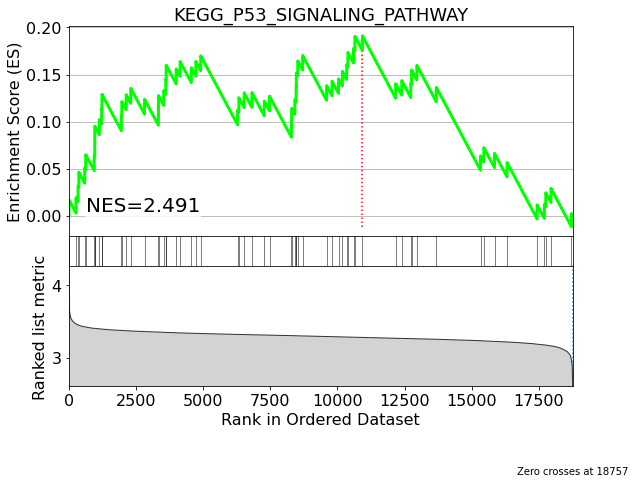

In [ ]:
# plot the enrichment results and save to pdf
fig = blitz.plot.running_sum(signature, "KEGG_P53_SIGNALING_PATHWAY", 
                             c2_kegg_gmt, 
                             result_kegg, compact=False)
fig.savefig("plots/CRISPRi-rho-gsea-KEGG_P53_SIGNALING_PATHWAY.pdf", bbox_inches='tight')

### KEGG_ACUTE_MYELOID_LEUKEMIA

In [ ]:
result_kegg.loc['KEGG_ACUTE_MYELOID_LEUKEMIA',:].leading_edge

'PIK3R1,MAP2K2,PIK3R5,PIK3CD,MAP2K1,SOS1,RUNX1T1,PIM2,PIK3R2,RAF1,PIK3CG,BRAF,NFKB1,NRAS,MAPK1,MAPK3,LEF1,CCND1,STAT3,TCF7L2,RPS6KB1,AKT1,PIK3CB,CEBPA,TCF7L1,RUNX1,KIT'

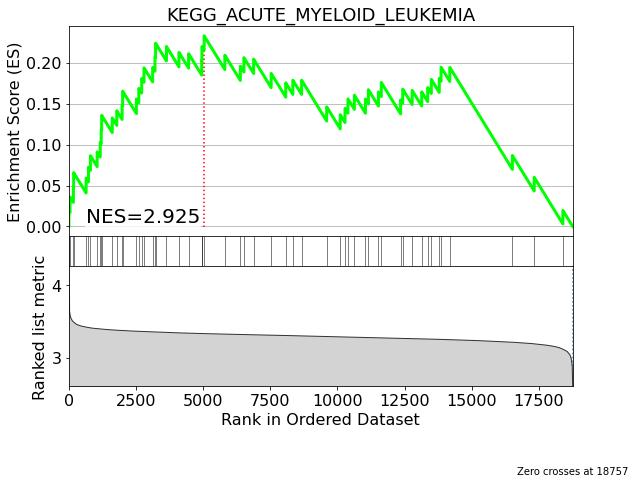

In [ ]:
# plot the enrichment results and save to pdf
fig = blitz.plot.running_sum(signature, "KEGG_ACUTE_MYELOID_LEUKEMIA", 
                             c2_kegg_gmt, 
                             result_kegg, compact=False)
fig.savefig("plots/CRISPRi-rho-gsea-KEGG_ACUTE_MYELOID_LEUKEMIA.pdf", bbox_inches='tight')

### GOBP_RNA_MODIFICATION

In [ ]:
result_go.loc['GOBP_RNA_MODIFICATION',:].leading_edge

'ANKRD16,FTSJ3,ALKBH1,KTI12,TRIT1,RPUSD4,METTL4,TRMT10C,ELP3,METTL14,TRMT12,TRUB2,URM1,NSUN6,SSB,ELP6,TRMT10A,DUS2,RBM15,TPRKB,GTPBP3,PUS7,ZC3H13,NAF1,PARN,ELP2,CBLL1,TRMT2B,TARBP1,PUSL1,DUS1L,METTL1,METTL8,CTU2,NUDT16,FTO,METTL3,GAR1,PUS7L,MEPCE,MTO1,MOCS3,RPUSD3,TRUB1,RPUSD2,AICDA,RNMT,DKC1,DIMT1,ZCCHC4,ELP5,WDR4,TRMT11,NSUN4,METTL5,BCDIN3D,CTU1,AARS2,ELP4,THADA,ALKBH8'

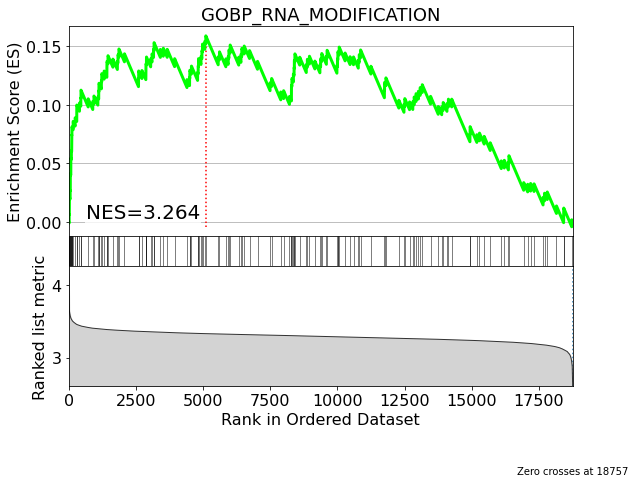

In [ ]:
# plot the enrichment results and save to pdf
fig = blitz.plot.running_sum(signature, "GOBP_RNA_MODIFICATION", 
                             c5_go_gmt, 
                             result_go, compact=False)
fig.savefig("plots/CRISPRi-rho-gsea-GOBP_RNA_MODIFICATION.pdf", bbox_inches='tight')

### GOCC_SPLICEOSOMAL_COMPLEX

In [ ]:
result_go.loc['GOCC_SPLICEOSOMAL_COMPLEX',:].leading_edge

'RBM3,PNN,SNRPF,CTNNBL1,RBMXL2,CWF19L1,ZRSR2,SNW1,HNRNPU,PRPF8,SNRNP40,HNRNPF,WBP4,ZCRB1,HNRNPH3,SYF2,SREK1,ZNF830,HNRNPR,LSM2,PPIL3,PPIE,AAR2,SYNCRIP,SNRPC,SNRNP70,LSM5,AQR,SF3B5,PPIL1,HNRNPK,BUD13,LUC7L3,WBP11,PHF5A'

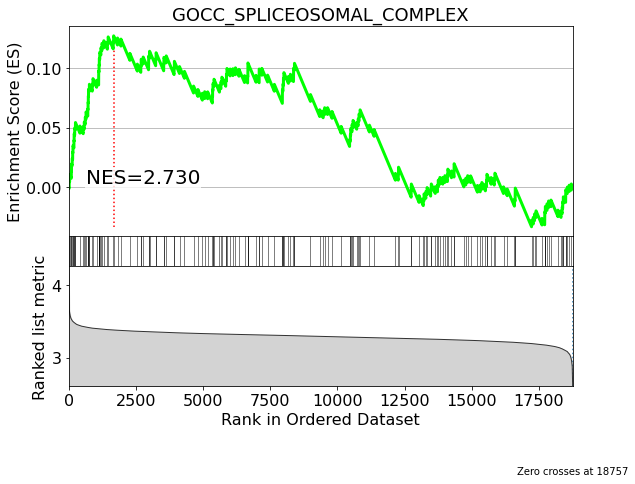

In [ ]:
# plot the enrichment results and save to pdf
fig = blitz.plot.running_sum(signature, "GOCC_SPLICEOSOMAL_COMPLEX", 
                             c5_go_gmt, 
                             result_go, compact=False)
# fig.savefig("plots/gesa_running_sum_GOBP_RNA_MODIFICATION.pdf", bbox_inches='tight')

### GOBP_RNA_SPLICING

In [ ]:
result_go.loc['GOBP_RNA_SPLICING',:].leading_edge

'PPIG,CWF19L1,ZRSR2,METTL14,HNRNPU,FAM172A,ZCRB1,POLR2L,RBM15,ZC3H13,SRSF10,ZNF830,PRMT7,METTL3,ACIN1,SYNCRIP,SNRPC,LSM5,GEMIN4,SF3B5,PPIL1,SNUPN,RBFOX2,HNRNPK,CELF3,LUC7L3,PPARGC1A,WBP11,GPATCH1,ESRP1,TSEN34,SRSF11,GEMIN8,PNN,SNRPF,CTNNBL1,POLR2A,SRPK3,TRA2B,SNRPB,ZNF326,RTCB,SNW1,PCBP2,DHX9,RAVER1,SNRNP40,IVNS1ABP,DAZAP1,PTBP1,HNRNPH3,SAP18,CSTF2,SREK1,HNRNPR,LSM2,THRAP3,PPIL3,SNIP1,PPIE,AAR2,DDX20,CSTF3,SNRNP70,AQR,SNRPA,POLR2D,RBM10,DDX1,PHF5A,RBM3,PRCC,PTBP3,PUF60,SCAF11,PRPF8,RBM19,CPSF7,REST,RBM4B,CPSF4,BUD13,CPSF3,RBMXL2,SLC38A2,KHDRBS2,METTL4,ZMAT5,DYRK1A,SF1,SF3B4,HNRNPF,WBP4,CPSF1,PPP1R9B,CHERP,PAPOLA,SYMPK,CELF4,SYF2,ZRANB2,RNPC3,SPEN,PRX,HNRNPH2,SRSF6,GEMIN5,PSIP1,RAVER2,ZC3H10,SRRT,SRPK1,WDR83,KHDRBS3'

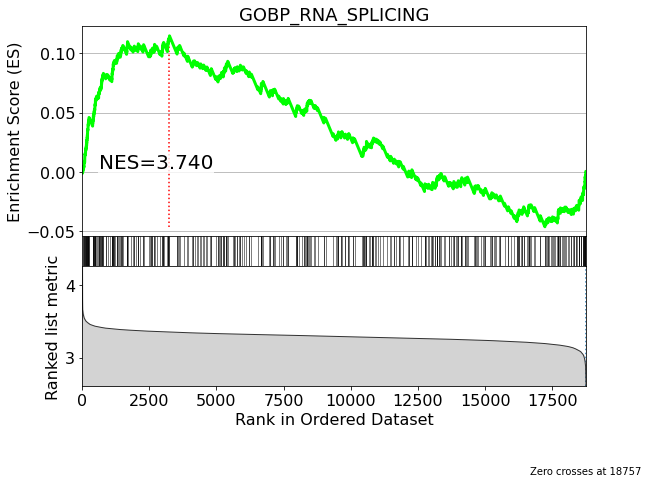

In [ ]:
# plot the enrichment results and save to pdf
fig = blitz.plot.running_sum(signature, "GOBP_RNA_SPLICING", 
                             c5_go_gmt, 
                             result_go, compact=False)
fig.savefig("plots/CRISPRi-rho-gsea-GOBP_RNA_SPLICING.pdf", bbox_inches='tight')

### GOCC_MRNA_EDITING_COMPLEX 

In [ ]:
result_go.loc['GOBP_MRNA_MODIFICATION',:].leading_edge

'PCIF1,METTL8,A1CF,PUS3,APOBEC1,TRMT61A,PUS1,METTL3,TRMT61B,PUS7,ZC3H13,TRUB1,TRMT10C,BAG4,METTL14,CBLL1,DKC1,APOBEC2'

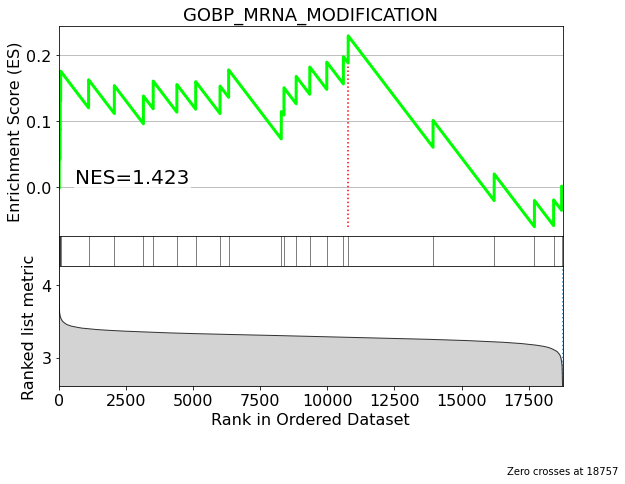

In [ ]:
# plot the enrichment results and save to pdf
fig = blitz.plot.running_sum(signature, "GOBP_MRNA_MODIFICATION", 
                             c5_go_gmt, 
                             result_go, compact=False)
fig.savefig("plots/CRISPRi-rho-gsea-GOBP_MRNA_MODIFICATION.pdf", bbox_inches='tight')

## Sensitivity hits

### INTS5 related 

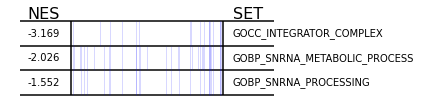

In [844]:
fig_table = blitz.plot.top_table(
    signature, c5_go_gmt, 
    result_go[result_go.leading_edge.str.contains('INTS5')],
    n=3
)

### GOCC_INTEGRATOR_COMPLEX

In [26]:
result_go.loc['GOCC_INTEGRATOR_COMPLEX',:].leading_edge

'INTS8,NIPBL,INTS12,INTS1,INTS9,INTS7,INTS5,INTS4,CT45A1,INTS6,SAGE1'

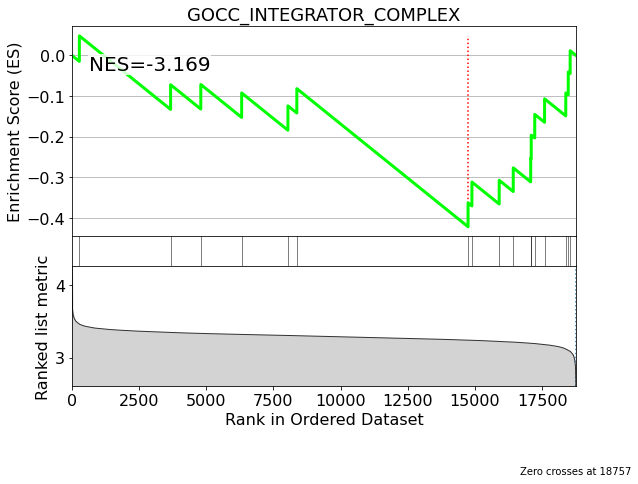

In [57]:
# plot the enrichment results and save to pdf
fig = blitz.plot.running_sum(signature, "GOCC_INTEGRATOR_COMPLEX", 
                             c5_go_gmt, 
                             result_go, compact=False)
fig#.savefig("plots/CRISPRi-rho-gsea-GOCC_INTEGRATOR_COMPLEX.pdf", bbox_inches='tight')

### GOMF_S_ADENOSYLMETHIONINE_DEPENDENT_METHYLTRANSFERASE_ACTIVITY

In [52]:
result_go.loc['GOMF_S_ADENOSYLMETHIONINE_DEPENDENT_METHYLTRANSFERASE_ACTIVITY',:].leading_edge

'EZH2,N6AMT1,PNMT,FTSJ3,NSD1,METTL4,DPH5,DNMT3A,TRMT10C,METTL14,KMT2A,WDR82,KMT2D,NSUN6,ICMT,METTL22,TRMT10A,SETD2,METTL1,TRMT2B,TARBP1,METTL21C,ASMT,SMYD3,METTL8,PRMT7,METTL3,MEPCE,PRDM9,RNMT,DIMT1,COQ5,PEMT,ZCCHC4,EED,METTL18,WDR4,MEN1,DNMT3B,NSUN4,CARM1,SMYD2,TRMT11,COMTD1,METTL5,DOT1L,ASH1L,SETD1A,COQ3'

In [60]:
# # plot the enrichment results and save to pdf
# fig = blitz.plot.running_sum(signature, "GOMF_S_ADENOSYLMETHIONINE_DEPENDENT_METHYLTRANSFERASE_ACTIVITY", 
#                              c5_go_gmt, 
#                              result_go, compact=False)
# fig#.savefig("plots/CRISPRi-rho-gsea-GOMF_S_ADENOSYLMETHIONINE_DEPENDENT_METHYLTRANSFERASE_ACTIVITY.pdf", bbox_inches='tight')

### GOBP_NEGATIVE_REGULATION_OF_INTRINSIC_APOPTOTIC_SIGNALING_PATHWAY_BY_P53_CLASS_MEDIATOR

In [ ]:
result_go.loc['GOBP_NEGATIVE_REGULATION_OF_INTRINSIC_APOPTOTIC_SIGNALING_PATHWAY_BY_P53_CLASS_MEDIATOR',:].leading_edge

'CD74,MUC1,KDM1A,CD44,BCL2,ARMC10,PTTG1IP,TRIAP1'

In [59]:
# # plot the enrichment results and save to pdf
# fig = blitz.plot.running_sum(
#     signature, 
#     "GOBP_NEGATIVE_REGULATION_OF_INTRINSIC_APOPTOTIC_SIGNALING_PATHWAY_BY_P53_CLASS_MEDIATOR", 
#     c5_go_gmt, 
#     result_go, compact=False)

# fig

### GOBP_REGULATION_OF_ENDOPLASMIC_RETICULUM_UNFOLDED_PROTEIN_RESPONSE

In [ ]:
result_go.loc['GOBP_REGULATION_OF_ENDOPLASMIC_RETICULUM_UNFOLDED_PROTEIN_RESPONSE',:].leading_edge

'FICD,NCK1,ERN1,XBP1,DDRGK1,PTPN2,PIK3R1,ATF6,BAK1,HSPA5,ATF6B,BAX,PPP1R15A,COPS5,ABCA7,BOK,PTPN1,BCL2L11,DNAJB9'

In [58]:
# # plot the enrichment results and save to pdf
# fig = blitz.plot.running_sum(
#     signature, 
#     "GOBP_REGULATION_OF_ENDOPLASMIC_RETICULUM_UNFOLDED_PROTEIN_RESPONSE", 
#     c5_go_gmt, result_go, compact=False
# )

# fig.savefig("plots/CRISPRi-rho-gsea-GOBP_REGULATION_OF_ENDOPLASMIC_RETICULUM_UNFOLDED_PROTEIN_RESPONSE.pdf", bbox_inches='tight')

### KEGG_RNA_DEGRADATION

In [ ]:
result_kegg.loc['KEGG_RNA_DEGRADATION',:].leading_edge

'EDC3,CNOT6L,CNOT4,PATL1,EXOSC6,DCPS,ENO2,CNOT8,LSM7,LSM3,CNOT3,MPHOSPH6,DDX6,CNOT2,CNOT6,EXOSC9,CNOT7,TTC37,CNOT10,EXOSC10,C1D,ENO1,EXOSC1,DCP1A,SKIV2L,EXOSC4,EXOSC3,WDR61,DCP2,CNOT1,DIS3'

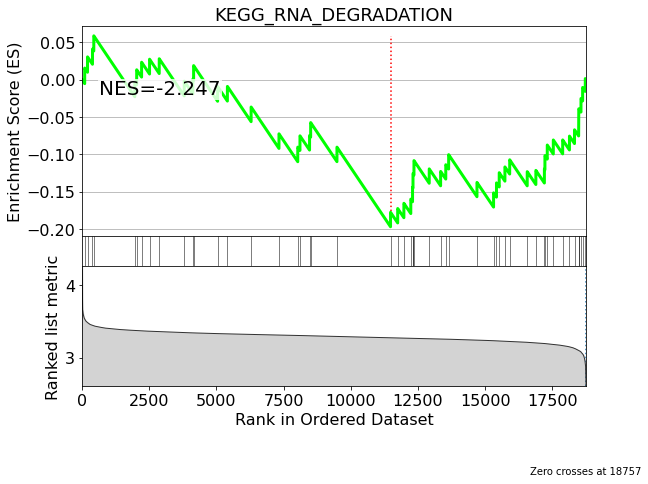

In [ ]:
# plot the enrichment results and save to pdf
fig = blitz.plot.running_sum(signature, "KEGG_RNA_DEGRADATION", 
                             c2_kegg_gmt, 
                             result_kegg, compact=False)

fig.savefig("plots/CRISPRi-rho-gsea-KEGG_RNA_DEGRADATION.pdf", bbox_inches='tight')

# 

In [846]:
!date

Sat Sep 17 19:20:21 PDT 2022
